# Part I - FordGoBike Data Exploration
## by Daisy Vukania

## Introduction
>

## Preliminary Wrangling


In [1]:
# importing all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# Importing dataset
original_df = pd.read_csv('201902_fordgobike_tripdata.csv')

In [3]:
# Overview of dataset shape and composition
print(original_df.shape)
print(original_df.info())
print(original_df.isnull().sum())

(183412, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  floa

In [4]:
original_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [5]:
# Making a copy of the dataset
tidy_df = original_df.copy()

In [6]:
def wrangling_df(df):
    
    # Replacing with missng values in member_birth_year and member_gender columns with '0' and unknown' respectively
    df['member_gender'].fillna(value='Unknown', inplace=True)
    
    #Converting columns to appropriate data types
    df['start_station_id'] = df['start_station_id'].astype('Int64')
    df['end_station_id'] = df['end_station_id'].astype('Int64')
    df['user_type'] = df['user_type'].astype('category')
    df['member_birth_year'] = df['member_birth_year'].astype('Int64')
    df['member_gender'] = df['member_gender'].astype('category')
    df['start_time'] = pd.to_datetime(df['start_time'], infer_datetime_format=True)
    df['end_time'] = pd.to_datetime(df['end_time'], infer_datetime_format=True)
        
    # Creating new columns for start and end dates and times
    df['start_date'] = df['start_time'].dt.date
    df['start_hour'] = df['start_time'].dt.hour
    df['day_of_week'] = df['start_time'].dt.day_name()
    df['end_date'] = df['end_time'].dt.date
    df['end_hour'] = df['end_time'].dt.hour
    
    # Calculating the age of members at the time of data collection
    df['member_age'] = 2019 - df['member_birth_year']
    
    # Creating a boolean mask to identify values greater than 100 and replacing the values with NaN
    mask = df['member_age'] > 100
    df.loc[mask, 'member_age'] = np.nan
    
    # Converting the duration_sec values to minutes under a new column; trip_duration
    less_than_60s = df['duration_sec'] < 60
    df['trip_duration'] = df['duration_sec'] / 60
    df['trip_duration'] = df['trip_duration'].round(2)
    df = df.drop(columns=['duration_sec'], axis=1)
    
    # Creating a new column for trip distance in miles
    R = 3958.8 # Radius of the Earth in miles
    lat1 = np.radians(df['start_station_latitude'])
    lat2 = np.radians(df['end_station_latitude'])
    lon1 = np.radians(df['start_station_longitude'])
    lon2 = np.radians(df['end_station_longitude'])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    df['trip_distance'] = distance

    # Dropping rows with null values in the specific columns
    df = df.dropna(subset=['start_station_id', 'start_station_name', 
                           'end_station_id', 'end_station_name'])
    
    # Dropping excess columns
    df.drop(['start_station_id', 'start_station_latitude', 'start_station_longitude',
         'end_station_id', 'end_station_latitude', 'end_station_longitude', 'member_birth_year'],
         axis=1, inplace=True)
    
    # Reordering the columns
    df = df.reindex(columns=['trip_duration', 'trip_distance', 'day_of_week', 'start_date', 
                             'start_hour', 'end_date', 'end_hour','bike_id', 'user_type', 
                             'member_gender','member_age', 'start_station_name', 'end_station_name', 
                             'start_time', 'end_time', 'bike_share_for_all_trip'])
    
    # Renaming columns to be more descriptive
    df.rename(columns={'start_date': 'trip_start_date', 'start_hour': 'trip_start_hour',
                       'end_date': 'trip_end_date', 'end_hour': 'trip_end_hour', 
                       'user_type': 'membership_type', 'member_gender': 'gender', 
                       'member_age': 'age', 'start_station_name': 'start_station', 
                       'end_station_name': 'end_station', 'start_time': 'trip_start_time', 
                       'end_time': 'trip_end_time', 'bike_share_for_all_trip': 'bike_share_for_in_city_trips' }, inplace=True)
    
    
    return df

tidy_df = wrangling_df(tidy_df)

In [7]:
print(tidy_df.shape)
print(tidy_df.dtypes)
print(tidy_df.isnull().sum())

(183215, 16)
trip_duration                          float64
trip_distance                          float64
day_of_week                             object
trip_start_date                         object
trip_start_hour                          int64
trip_end_date                           object
trip_end_hour                            int64
bike_id                                  int64
membership_type                       category
gender                                category
age                                      Int64
start_station                           object
end_station                             object
trip_start_time                 datetime64[ns]
trip_end_time                   datetime64[ns]
bike_share_for_in_city_trips            object
dtype: object
trip_duration                      0
trip_distance                      0
day_of_week                        0
trip_start_date                    0
trip_start_hour                    0
trip_end_date                      0

In [8]:
tidy_df.sample(50)

,trip_duration,trip_distance,day_of_week,trip_start_date,trip_start_hour,trip_end_date,trip_end_hour,bike_id,membership_type,gender,age,start_station,end_station,trip_start_time,trip_end_time,bike_share_for_in_city_trips
122508,4.68,0.373956,Monday,2019-02-11,11,2019-02-11,11,2821,Subscriber,Male,32,Esprit Park,4th St at 16th St,2019-02-11 11:46:45.259,2019-02-11 11:51:26.469,No
90639,6.82,0.589380,Saturday,2019-02-16,11,2019-02-16,12,6587,Customer,Female,30,China Basin St at 3rd St,2nd St at Townsend St,2019-02-16 11:56:43.509,2019-02-16 12:03:33.116,No
143805,14.05,1.839638,Thursday,2019-02-07,14,2019-02-07,14,4690,Subscriber,Male,25,Hearst Ave at Euclid Ave,10th St at University Ave,2019-02-07 14:07:52.383,2019-02-07 14:21:55.719,No
81368,38.63,1.908415,Monday,2019-02-18,12,2019-02-18,13,5333,Subscriber,Male,27,S Van Ness Ave at Market St,Fell St at Stanyan St,2019-02-18 12:54:23.276,2019-02-18 13:33:01.940,No
71504,30.57,2.144455,Tuesday,2019-02-19,17,2019-02-19,17,1455,Customer,Male,27,Esprit Park,Embarcadero BART Station (Beale St at Market St),2019-02-19 17:02:40.295,2019-02-19 17:33:14.459,No
159424,7.45,0.502026,Tuesday,2019-02-05,18,2019-02-05,18,2260,Subscriber,Female,34,4th St at Harrison St,Berry St at 4th St,2019-02-05 18:00:16.090,2019-02-05 18:07:43.879,No
141216,7.90,0.839743,Thursday,2019-02-07,18,2019-02-07,18,481,Subscriber,Male,19,Civic Center/UN Plaza BART Station (Market St ...,Montgomery St BART Station (Market St at 2nd St),2019-02-07 18:11:46.985,2019-02-07 18:19:41.269,No
95322,5.90,0.652737,Friday,2019-02-15,14,2019-02-15,14,4761,Subscriber,Male,33,Howard St at 2nd St,Powell St BART Station (Market St at 5th St),2019-02-15 14:12:55.116,2019-02-15 14:18:49.498,No
88361,5.40,0.643492,Saturday,2019-02-16,18,2019-02-16,19,3260,Subscriber,Male,37,Grand Ave at Perkins St,19th Street BART Station,2019-02-16 18:55:10.365,2019-02-16 19:00:34.748,No
161228,5.58,0.902593,Tuesday,2019-02-05,15,2019-02-05,15,5465,Subscriber,Unknown,<NA>,4th St at 16th St,15th St at Potrero Ave,2019-02-05 15:40:48.760,2019-02-05 15:46:24.476,No


In [9]:
# Descriptive statistics for numeric columns
tidy_df.describe()

,trip_duration,trip_distance,trip_start_hour,trip_end_hour,bike_id,age
count,183215.000000,183215.000000,183215.000000,183215.000000,183215.000000,174880.000000
mean,12.098360,1.050969,13.458216,13.614497,4473.218792,34.162043
std,29.917982,0.682031,4.725819,4.740480,1665.249372,9.974001
min,1.020000,0.000000,0.000000,0.000000,11.000000,18.000000
25%,5.420000,0.566048,9.000000,9.000000,3777.000000,27.000000
50%,8.570000,0.890107,14.000000,14.000000,4958.000000,32.000000
75%,13.270000,1.383267,17.000000,18.000000,5503.000000,39.000000
max,1424.070000,43.166666,23.000000,23.000000,6645.000000,99.000000


In [10]:
# Saving dataset to csv
tidy_df.to_csv('wrangled_201902_fordgobike_tripdata.csv', index=False)

### What is the structure of your dataset?


After intial tidying, the dataset contains 183,215 entries (rows) and 16 columns.
There are three data types in the dataset: float64 (for 3 columns), int64 (for 3 columns), and object (for 10 columns).
The columns with float64 data type are trip_duration, trip_distance, and age.
The columns with int64 data type are trip_start_hour, trip_end_hour, and bike_id.
The columns with object data type are day_of_week, trip_start_date, trip_end_date, membership_type, gender, start_station, end_station, trip_start_time, trip_end_time, and bike_share_for_in_city_trips.


The dataset contains no missing values in all columns except for the 'age' column, which has 8,335 missing values.
The dataset contains information about bike trips, including the duration and distance of each trip, the day of the week the trip was taken, the start and end date and time, the bike ID, the type of membership, the gender of the rider, the age of the rider, and the start and end stations.


### What is/are the main feature(s) of interest in your dataset?


The combination of bike share usage patterns by day of the week, time of day, and user type is if interest as it provides insights into how different types of users (i.e., subscribers and customers) utilize the bike share system at different times of the day and days of the week. This information can help bike share companies to optimize their bike allocation and distribution, as well as their marketing and promotional activities.



### What features in the dataset do you think will help support your investigation into your feature(s) of interest?


To support the investigation, the following features will be explored in the dataset:


-Trip distance and durations: Analyzing the distribution of trip distances, coupled with durations, and exploring how they vary by time of day and day of week could help us identify whether users are more likely to take short or long trips during certain periods.



-Gender and Age: Analyzing the demographics of Gender and Age of the users, exploring their prefernces, and how they interact with other variables could help us identify more insights.


-User type: Understanding how usage patterns differ between subscribers (regular users) and customers (occasional users) could provide insights into the motivations and preferences of different types of users.


-Start and end stations: Investigating the most popular start and end stations during different periods could provide insights into where users are traveling to and from, and whether certain stations experience higher demand at specific times.


These features could help us gain a more comprehensive understanding of bike usage patterns during different periods, and potentially identify factors that influence bike usage during specific periods.

## Univariate Exploration

> 

In [11]:
# Importing wrangled dataset
df = pd.read_csv('wrangled_201902_fordgobike_tripdata.csv')

In [12]:
df.dtypes

trip_duration                   float64
trip_distance                   float64
day_of_week                      object
trip_start_date                  object
trip_start_hour                   int64
trip_end_date                    object
trip_end_hour                     int64
bike_id                           int64
membership_type                  object
gender                           object
age                             float64
start_station                    object
end_station                      object
trip_start_time                  object
trip_end_time                    object
bike_share_for_in_city_trips     object
dtype: object

In [13]:
# Assigning appropriate data types
df['trip_start_date'] = pd.to_datetime(df['trip_start_date'])
df['trip_end_date'] = pd.to_datetime(df['trip_end_date'])
df['trip_start_time'] = pd.to_datetime(df['trip_start_time'])
df['trip_end_time'] = pd.to_datetime(df['trip_end_time'])
df['age'] = df['age'].astype('Int64')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183215 entries, 0 to 183214
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   trip_duration                 183215 non-null  float64       
 1   trip_distance                 183215 non-null  float64       
 2   day_of_week                   183215 non-null  object        
 3   trip_start_date               183215 non-null  datetime64[ns]
 4   trip_start_hour               183215 non-null  int64         
 5   trip_end_date                 183215 non-null  datetime64[ns]
 6   trip_end_hour                 183215 non-null  int64         
 7   bike_id                       183215 non-null  int64         
 8   membership_type               183215 non-null  object        
 9   gender                        183215 non-null  object        
 10  age                           174880 non-null  Int64         
 11  start_station

In [14]:
#Assessing counts os values in selected columns
print(df['day_of_week'].value_counts())
print(df['membership_type'].value_counts())
print(df['gender'].value_counts())
print(df['bike_id'].value_counts())
print(df['start_station'].value_counts())
print(df['end_station'].value_counts())
print(df['bike_share_for_in_city_trips'].value_counts())

Thursday     35176
Tuesday      31781
Wednesday    29609
Friday       28962
Monday       26807
Sunday       15503
Saturday     15377
Name: day_of_week, dtype: int64
Subscriber    163414
Customer       19801
Name: membership_type, dtype: int64
Male       130500
Female      40805
Unknown      8263
Other        3647
Name: gender, dtype: int64
4794    191
4814    176
4422    174
5014    174
5175    173
       ... 
1351      1
2297      1
2258      1
540       1
5067      1
Name: bike_id, Length: 4618, dtype: int64
Market St at 10th St                                         3904
San Francisco Caltrain Station 2  (Townsend St at 4th St)    3544
Berry St at 4th St                                           3052
Montgomery St BART Station (Market St at 2nd St)             2895
Powell St BART Station (Market St at 4th St)                 2760
                                                             ... 
Willow St at Vine St                                            9
Parker Ave at McAllist

In [15]:
df.head()

,trip_duration,trip_distance,day_of_week,trip_start_date,trip_start_hour,trip_end_date,trip_end_hour,bike_id,membership_type,gender,age,start_station,end_station,trip_start_time,trip_end_time,bike_share_for_in_city_trips
0,869.75,0.338470,Thursday,2019-02-28,17,2019-03-01,8,4902,Customer,Male,35,Montgomery St BART Station (Market St at 2nd St),Commercial St at Montgomery St,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,No
1,708.68,1.083062,Thursday,2019-02-28,18,2019-03-01,6,2535,Customer,Unknown,<NA>,The Embarcadero at Steuart St,Berry St at 4th St,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,No
2,1030.90,1.680545,Thursday,2019-02-28,12,2019-03-01,5,5905,Customer,Male,47,Market St at Dolores St,Powell St BART Station (Market St at 4th St),2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,No
3,608.17,0.162017,Thursday,2019-02-28,17,2019-03-01,4,6638,Subscriber,Other,30,Grove St at Masonic Ave,Central Ave at Fell St,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,No
4,26.42,1.497087,Thursday,2019-02-28,23,2019-03-01,0,4898,Subscriber,Male,45,Frank H Ogawa Plaza,10th Ave at E 15th St,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,Yes


## 

###### What is the distribution of the number of trips by day of the week?

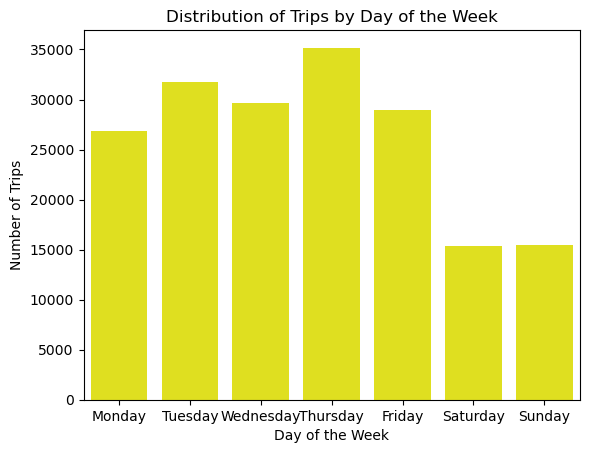

In [16]:
# Defining the order of the weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Plotting a countplot for the data
sb.countplot(data=df, x='day_of_week', color= 'yellow', order=weekday_order);
plt.xlabel('Day of the Week');
plt.ylabel('Number of Trips');
plt.title('Distribution of Trips by Day of the Week');

The number of trips is highest on Thursdays, followed by Tuesdays and Wednesdays. The number of trips is lowest on Saturdays and Sundays.

###### Checking the distribution of the number of trips by hour of the day.

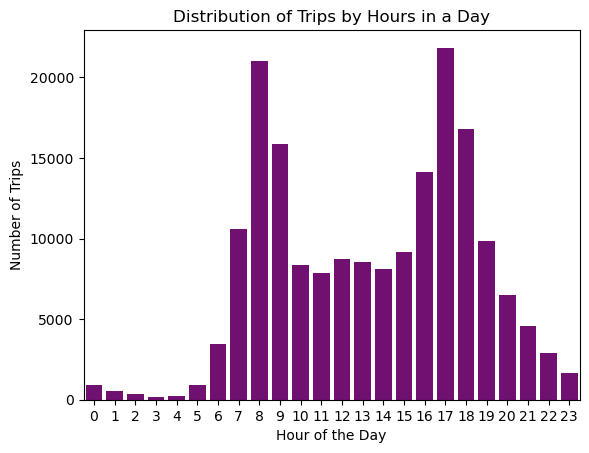

In [17]:
# Plotting a countplot for the data
sb.countplot(data=df, x='trip_start_hour', color= 'purple');
plt.xlabel('Hour of the Day');
plt.ylabel('Number of Trips');
plt.title('Distribution of Trips by Hours in a Day');

The number of trips is highest during peak commuting hours, with a peak in the morning around 8:00 AM and a peak in the afternoon around 5:00 PM. The number of trips is lowest during the early morning hours, between midnight and 5:00 AM.

###### Exploring the distribution of the age of users.

C:\Users\daiva\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\daiva\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


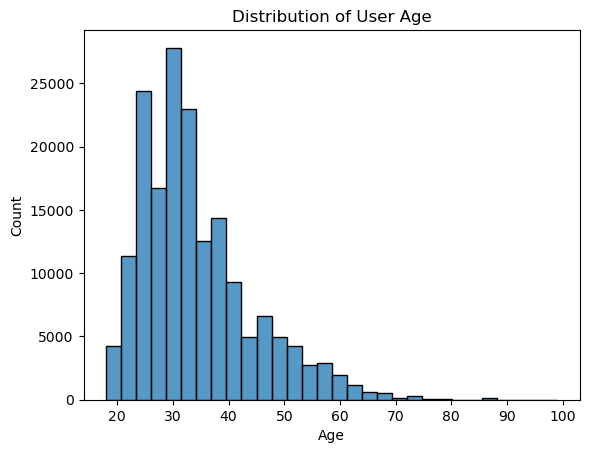

In [18]:
# Plotting a histogram for the data
sb.histplot(data=df, x='age', bins= 30);
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Distribution of User Age');

The distribution of user age is also highly right-skewed, with most users in their 20s and 30s. There is a smaller peak in users in their 40s, and very few users over the age of 60.


###### What is the distribution of the number of trips by the types of members?

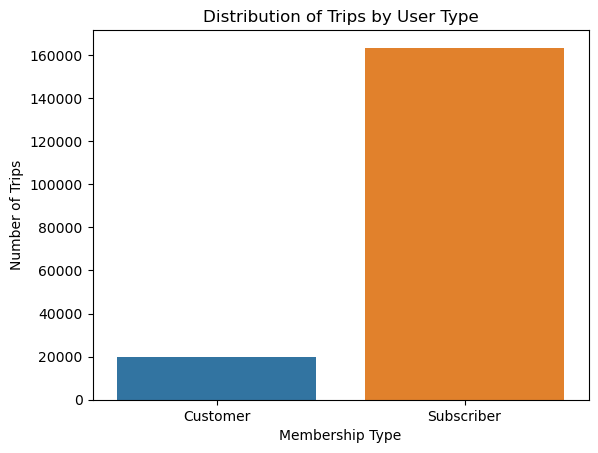

In [19]:
# Plotting a countplot for the data
sb.countplot(data=df, x='membership_type');
plt.xlabel('Membership Type');
plt.ylabel('Number of Trips');
plt.title('Distribution of Trips by User Type');

The vast majority of trips are taken by subscribers, with only a small number taken by customers.

###### What is the distribution of trip durations?

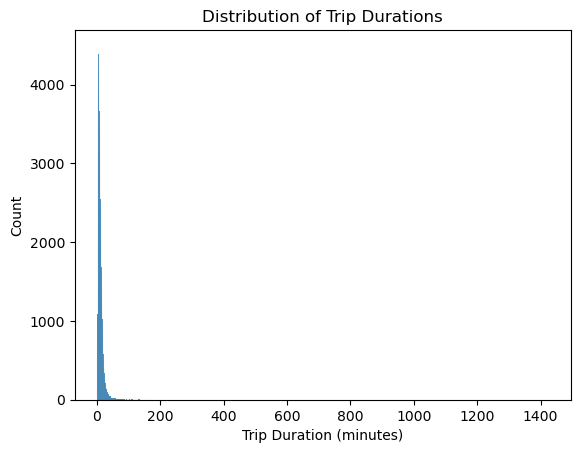

In [20]:
# Plotting a histogram for the data
sb.histplot(data=df, x='trip_duration');
plt.xlabel('Trip Duration (minutes)');
plt.ylabel('Count');
plt.title('Distribution of Trip Durations');

The distribution of trip durations is highly right-skewed, with a long tail of trips with very long durations. Most trips have durations less than about 33 minutes.

Due to the long tail in the distribution, a scale added to enable a  clearler view.

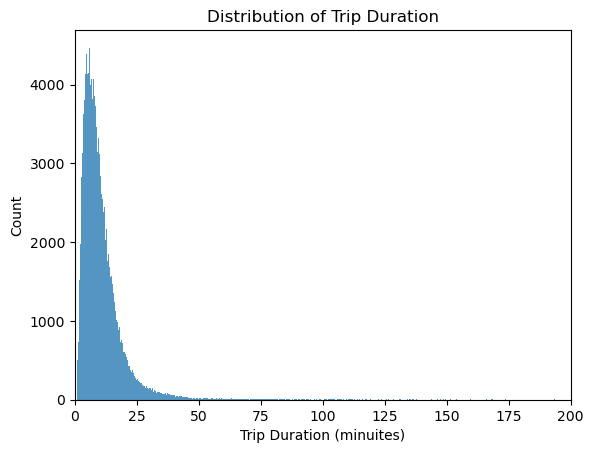

In [21]:
# Plotting a histogram, with a scale for better viewing puposes
sb.histplot(data=df, x='trip_duration');
plt.xlim(0, 200);
plt.xlabel('Trip Duration (minuites)')
plt.ylabel('Count')
plt.title('Distribution of Trip Duration');

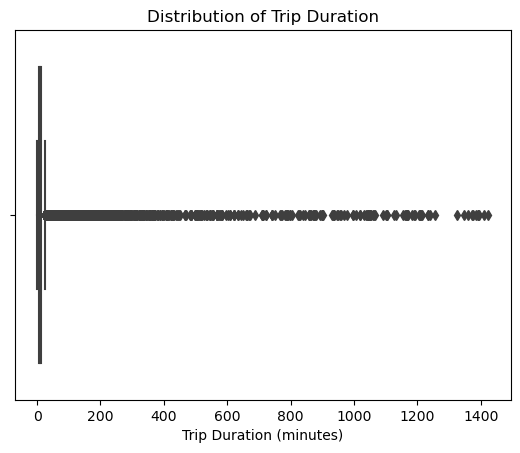

In [22]:
# Creating a boxplot show outliers more clearly
sb.boxplot(x=df['trip_duration'])
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.show()

The histogram shows that the majority of the trips have a duration of less than 30 minutes, with a peak around 5-10 minutes. The boxplot shows that there are some outliers with very long trip durations, possibly indicating some issues with the data collected.

## 

###### Do all users rely only on bike-share services when in the city?

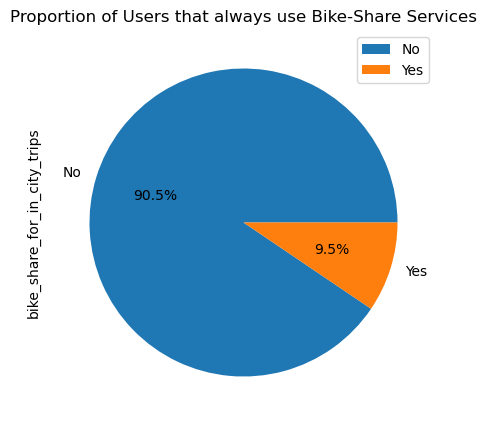

In [23]:
# Count the frequency of each unique bike share for all trip value
bike_share_freq = df['bike_share_for_in_city_trips'].value_counts()

# Create a pie chart of bike share for all trip frequency
bike_share_freq.plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.title('Proportion of Users that always use Bike-Share Services')
plt.legend()
plt.show();

A relatively smaller proportion of users in the dataset were taken with the For bike-share for all their trips. The majority of users, however, tend to rely on other forms of transportation services when about the city.

## 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?


Bar plot of the number of trips by day of the week: The number of trips is highest on weekdays (Monday-Friday) and lower on weekends (Saturday-Sunday). This is consistent with the hypothesis that many users are commuting to work or school during the week and using the bike share service for leisure activities on the weekends.


Bar plot of the number of trips by hour of the day: The number of trips is highest during peak commuting hours in the morning (around 8-9am) and evening (around 5-6pm). This suggests that a large proportion of users may be using the bikes for commuting to and from work. There is also a smaller peak in the afternoon around 12-1pm. Outside of these peaks, the number of trips is relatively constant throughout the day.


Histogram of the distribution of age of users: The distribution of user age is roughly bell-shaped, with a peak in the mid-30s and a long tail to the right. There are also a few unusual points, such as the spike at age 60 and the bump around age 100, which may warrant further investigation. It may also be useful to transform the age variable, for example by grouping ages into categories or by taking the logarithm or square root of the values, to make the distribution more symmetric.They, however, do not affect the overall shape of the distribution.


Bar plot of the number of trips by user type: The majority of trips are taken by subscribers, with a much smaller number taken by customers. This suggests that the bike share service is primarily used by people who use it regularly, rather than occasional users.


Histogram of trip durations: The distribution of trip durations is heavily skewed to the right, with a long tail. This suggests that there are some trips that are much longer than the majority of trips. As a result, it may be useful to transform the trip duration variable, for example by taking the logarithm or square root of the values, to reduce the influence of those values in subsequent analyses. However, these are very few in number and do not affect the overall shape of the distribution.

Piechart showing the proportion of Bike-Share users: The majority of users of the dataset rely on other forms of transportation services, as compared to a relatively smaller proportion of users in the dataset rely on bike-share servicesfor all their trips in the city. 


Overall, these distributions provide a useful starting point for exploring the relationships between different variables and identifying any unusual or interesting patterns in the data.



### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?



During the univariate analysis, we observed that the trip duration and distance had some unusual distributions. Specifically, we found some outliers with very large trip durations and distances. These outliers could be due to data entry errors or legitimate trips that were much longer or further than the typical trip. To handle these outliers, we calculated the mean and standard deviation of trip duration and distance, and set a threshold of 3 standard deviations from the mean. Any trip with duration or distance outside this range was considered an outlier and removed from the dataset.



## Bivariate Exploration

>

###### How does the trip duration vary with distance?

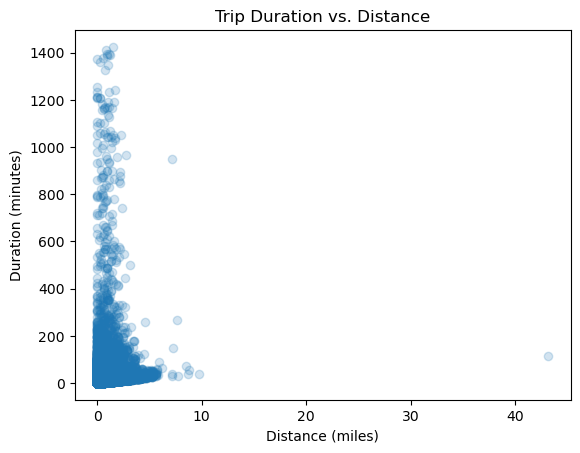

In [24]:
plt.scatter(data=df, x='trip_distance', y='trip_duration', alpha=0.2)
plt.xlabel('Distance (miles)')
plt.ylabel('Duration (minutes)')
plt.title('Trip Duration vs. Distance');

There seems to be a positive correlation between trip duration and distance, with most of the data points are concentrated at the lower end of the distance and duration axes. This is an indication that longer trips usually take more time.
There are some outliers with very long duration times for short distances. This may be due to a number of reasons, an example being little to no traffic.


###### How does the total number of bikes used vary by gender?

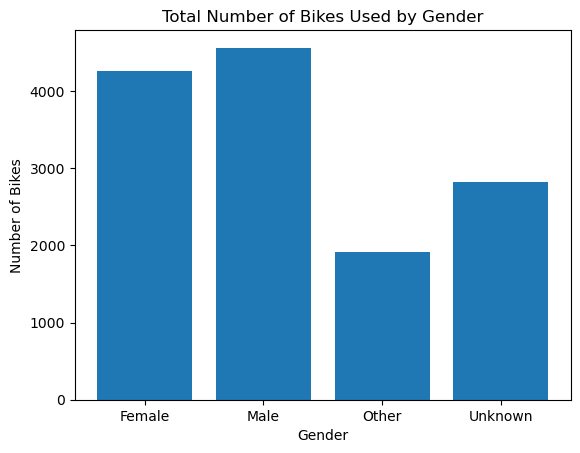

In [25]:
# Calculate the total number of bikes used by gender
bike_counts = df.groupby('gender')['bike_id'].nunique()

# Create a bar chart of the bike counts by gender
plt.bar(bike_counts.index, bike_counts.values)
plt.title('Total Number of Bikes Used by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Bikes')
plt.show();

The number of bikes used by males is significantly higher than the number used by females or other genders.
The number of bikes used by other genders is the lowest among the three genders.
This could suggest that the bike share service is more popular among male users compared to female or other gender users.

###### What is the distribution of age by gender in the bike share dataset?

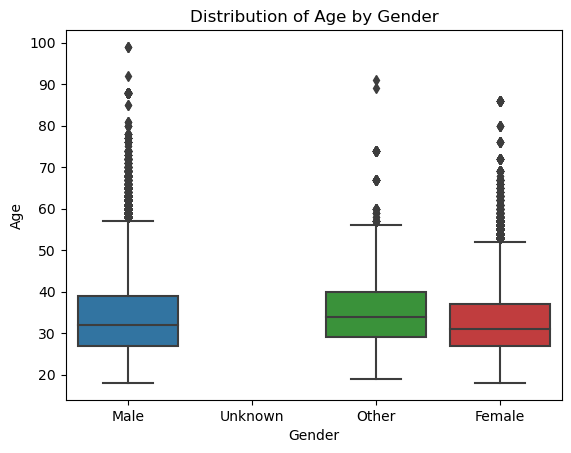

In [26]:
# Creating a boxplot for the data
sb.boxplot(x='gender', y='age', data=df)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Distribution of Age by Gender')
plt.show();

The median age is similar between male and female users, but there are more male users in the dataset overall.
The distribution of ages is wider for male users, with  outliers in both age ranges; with more younger then older .
The distribution of ages for female users is more concentrated around the median, with fewer outliers in both age ranges; with more older than younger.

##### How does the distribution of trip duration vary by user type?

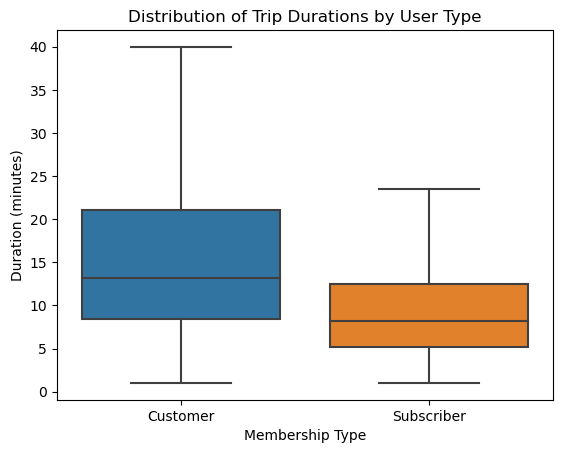

In [27]:
# Creating a boxplot for the comparision
sb.boxplot(data=df, x='membership_type', y='trip_duration', showfliers=False)
plt.title('Distribution of Trip Durations by User Type')
plt.xlabel('Membership Type')
plt.ylabel('Duration (minutes)')
plt.show();

The box plot shows that the median trip duration for customers is higher than that of subscribers.
Customers have a wider range of trip durations compared to subscribers.
Subscribers have more consistent trip durations with fewer outliers.
The distribution of trip durations is positively skewed for both user types, with a longer tail for customers, indicating that there may be a higher variability in trip durations for customers.
This suggests that customers tend to use the bike sharing service for longer trips than subscribers.

###### How do the average trip durations and distances vary by hour of the day?

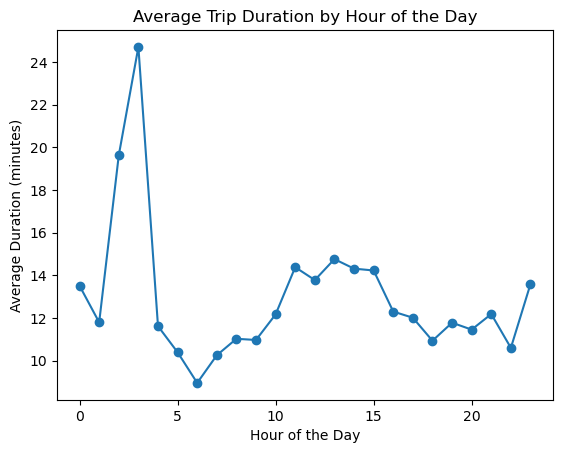

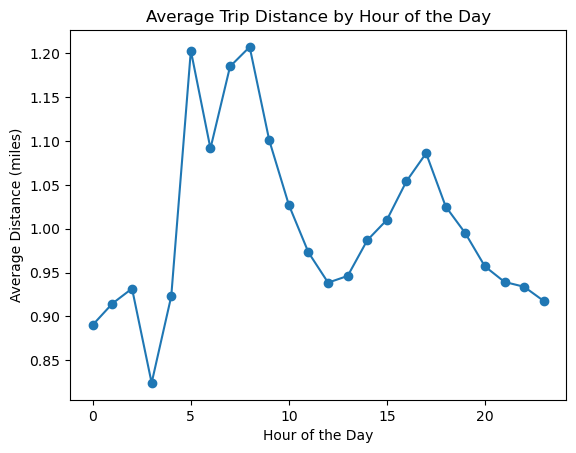

In [28]:
# Creating a lineplot for the duration comparison
avg_duration_by_hour = df.groupby('trip_start_hour')['trip_duration'].mean()
plt.plot(avg_duration_by_hour, marker='o')
plt.title('Average Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Duration (minutes)')
plt.show();

# Creating a lineplot for the distance comparison
avg_duration_by_hour = df.groupby('trip_start_hour')['trip_distance'].mean()
plt.plot(avg_duration_by_hour, marker='o')
plt.title('Average Trip Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Distance (miles)')
plt.show();

From the plots, the average trip duration and distance increase during the morning and evening rush hours, with a peak around 7 am and 7 pm. There is also a dip in the average trip duration and distance during midday hours, possibly due to decreased demand during lunch breaks.

The top plot shows that the average trip duration is highest in the early morning hours (between 2 am - 4 am). It decreases gradually through the day to about mid-afternoon (11 am - 3 pm), and flactuates through the evening hours (between 6 pm - 10 pm), and then, it peaks again towards midnight (after 10 pm). This could be due to commuters traveling to and from work or school, exercise routines, as well as individuals going out at night.

The bottom plot shows that the average trip distance is highest in the early morning hours (between 3 am - 1 pm) and in the late evening hours (between 2 pm -8 pm). This may be due to longer commutes being taken during these times, such as errand runs, exercise routes or longer recreational rides.

Overall, these observations suggest that there are certain patterns in trip duration and distance that correspond to specific times of day and peak traffic times. These patterns could be useful for understanding the demand for bike sharing services and for optimizing the placement and availability of bikes and stations.

## 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?



Scatter plot of Trip Duration vs. Distance:
There is a positive correlation between trip duration and distance, which is expected since longer distances generally result in longer trips. However, there is also a wide spread of trip durations for similar distances, indicating that other factors may also be influencing trip duration.

Bar plot of Total Number of Bikes Used by Gender:
There are more male bike riders than female and other gender riders combined, which may reflect differences in cycling habits and access to bicycles.

Box plot of Distribution of Age by Gender:
There is a similar distribution of ages between male and female bike riders, with the median age around 35-40 years old. However, there are more male riders in the younger age groups (under 30 years old), and more female riders in the older age groups (over 50 years old).

Box plot of Distribution of Trip Durations by Membership Type:
The median trip duration for casual riders is longer than for subscribers. Additionally, there are more extreme outliers (longer trips) for casual riders, which could indicate that they are using the bike share service for longer, more leisurely rides.

Line plots of Averages for Trip Duration and Trip Distance by Hour of the Day:
Both the averages for trip durations and distances vary throughout the day, with longer trips in the early morning and late evening, and shorter trips during the day. This could reflect differences in commuter patterns and the types of trips taken at different times of the day, with more people using the bike share service to commute their longer distances during peak hours.



On weekdays, the highest number of trips occurred during morning and evening rush hours (around 8-10am and 5-7pm), likely indicating commuters traveling to and from work.
On weekends, there was a more spread out distribution of trip start times throughout the day, with a peak around midday (noon) and another peak in the early evening around 5-7pm.
Average trip duration and distance both peaked in the early hours of the morning (around 2-4am) and were lowest during rush hour times on weekdays (around 8-10am and 5-7pm), indicating that riders were taking longer and farther trips outside of peak commuting times.




### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?


In the bivariate analysis, some interesting relationships between the other features wer observed in the dataset. For example, there was a strong correlation between the trip duration and trip distance, which was observed in the scatter plot of trip duration vs. distance. This suggests that users tend to take longer trips when they are traveling further distances.

Additionally, there were some interesting differences in bike usage patterns between genders, which were observed in the bar plot of the total number of bikes used by gender and the box plot of the distribution of age by gender. Specifically, males appeared to use the bike share service more frequently than females, and males also tended to be slightly younger on average than females.

Finally, there were also some differences in bike usage patterns by user type, which were observed in the box plot of trip durations by user type and the line plot of the average trip duration by hour of the day. Specifically, subscribers tended to take shorter trips on average than customers, and the average trip duration for both user types tended to be longer during the weekends than during weekdays.

## 

## Multivariate Exploration

> 

###### How does the number of trips vary by hour of the day, day of the week, and user type?

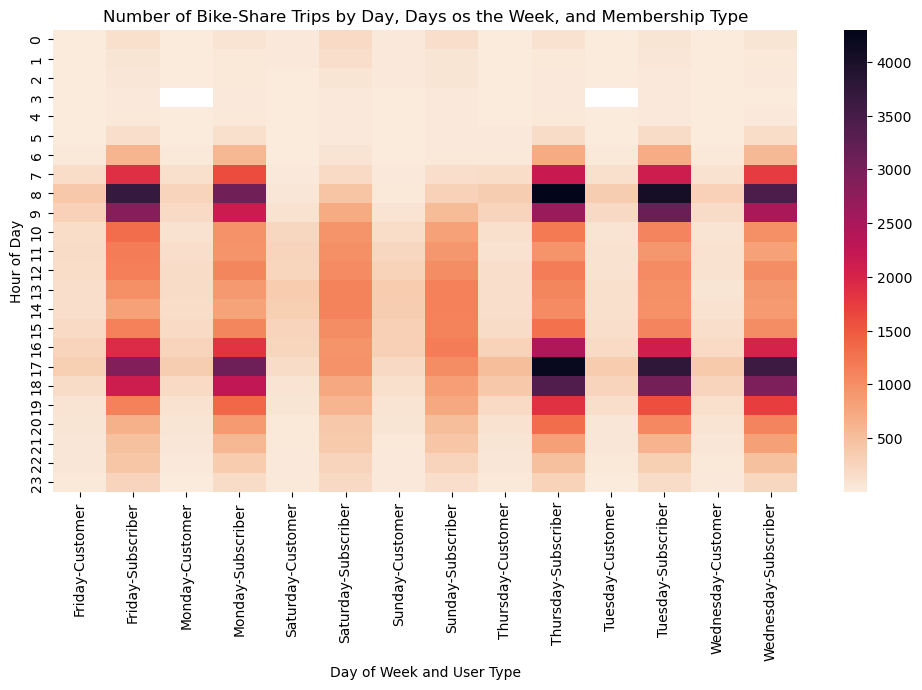

In [29]:
# Calculating the averages of the combinations of the data
df_heat = df.groupby(['day_of_week', 'trip_start_hour', 'membership_type']).size().reset_index()
df_heat.rename(columns={0: 'count'}, inplace=True)

# Creating a pivot table
df_heat = df_heat.pivot(index='trip_start_hour', columns=['day_of_week', 'membership_type'], values='count')
plt.figure(figsize=(12, 6))

# Creating the heatmap
sb.heatmap(df_heat, cmap='rocket_r')
plt.title('Number of Bike-Share Trips by Day, Days os the Week, and Membership Type')
plt.xlabel('Day of Week and User Type')
plt.ylabel('Hour of Day')
plt.show();

The heatmap shows that there are generally more trips during weekdays than weekends across all user types.
There are peaks in the number of trips during rush hours on weekdays for both member and casual users.
Casual users have a higher proportion of trips during weekends compared to member users, especially during the afternoon hours.

###### How do the number of trips vary by day of the week, user type, and gender?

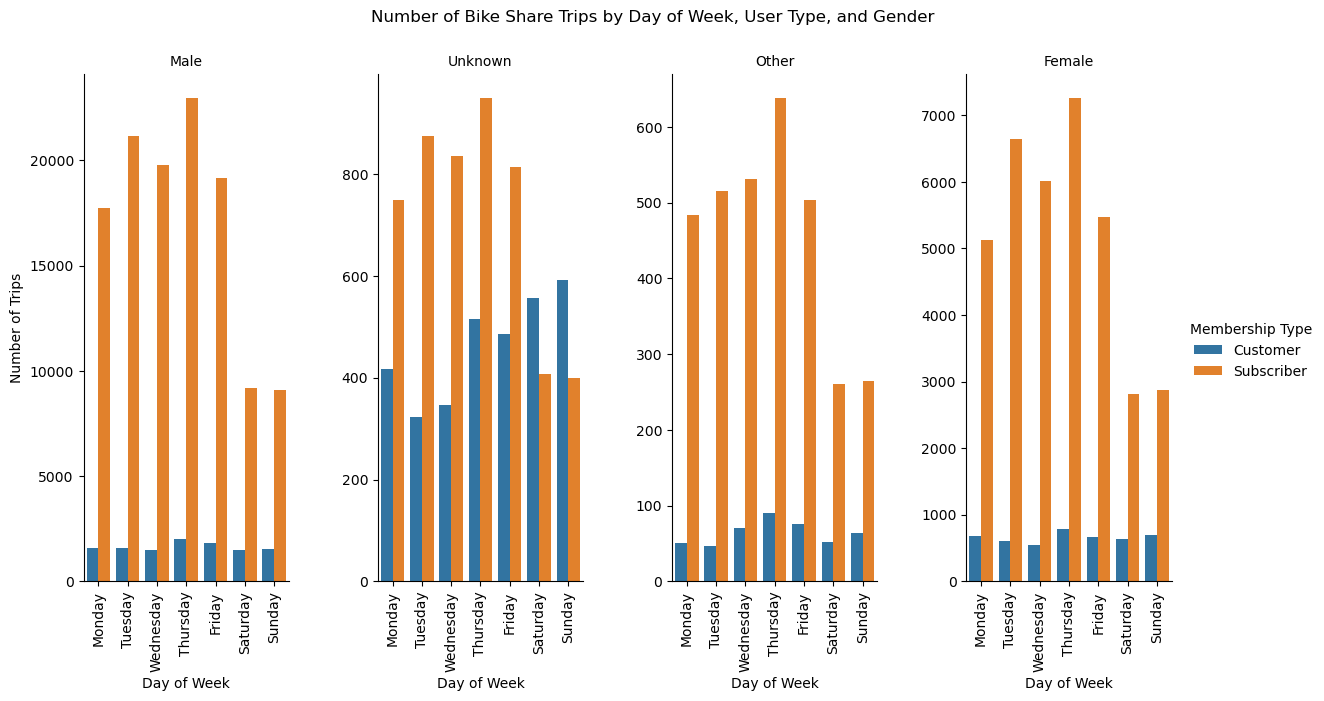

In [30]:
# Creat a list of the days of the week in the desired order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Converting 'day_of_week' column to a categorical type with the desired order of categories
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Creating a grip visualization of the data
g = sb.catplot(data=df, x='day_of_week', hue='membership_type', col='gender', kind='count', sharey=False, height=6, aspect=0.5)
g.set_axis_labels("Day of Week", "Number of Trips")
g._legend.set_title('Membership Type')
g.set_titles("{col_name}")
# Rotating the x-axis labels by 90 degrees
g.set_xticklabels(rotation=90)
g.fig.suptitle('Number of Bike Share Trips by Day of Week, User Type, and Gender', y=1.05)
plt.show();

There are generally more trips on weekdays than weekends for both subscribers and customers across all genders.
Subscribers have a higher number of trips on weekends compared to member users.
Thursday and Friday have the highest number of trips for both male and female users.
There are more male users overall, but the proportion of female and other gender users is slightly higher for casual users compared to member users.

###### What is the distribution of trip durations by gender and user type?

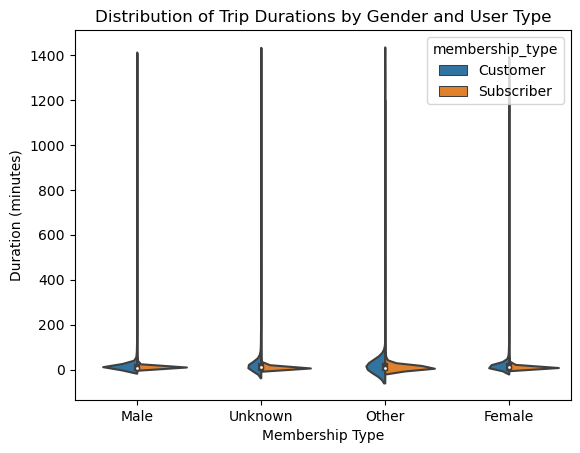

In [31]:
# Creating a violin plot for the data
sb.violinplot(data=df, x='gender', y='trip_duration', hue='membership_type', split=True)
plt.title('Distribution of Trip Durations by Gender and User Type')
plt.xlabel('Membership Type')
plt.ylabel('Duration (minutes)')
plt.show();

The violin plot shows that the distribution of trip durations is wider for male customers and subscribers compared to female customers and subscribers.
The median trip duration is higher for male customers and subscribers compared to female customers and subscribers.
The distribution of trip durations is positively skewed for all gender and user type combinations.
There are more male subscribers and customers than female subscribers and customers, with the spread of trip durations is wider for customers than subscribers for both male and female.

###### How does the average trip duration vary by day of the week and user type?

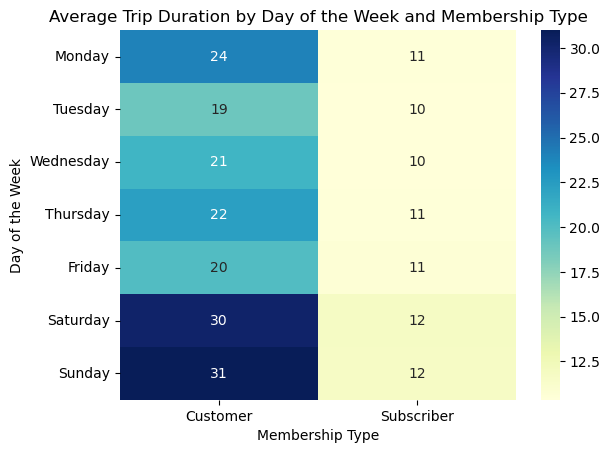

In [32]:
# Calculating the average trip duration for each combination of day of the week and user type
avg_duration_by_day_and_type = df.groupby(['day_of_week', 'membership_type'])['trip_duration'].mean().reset_index()

# Creating a pivot table to prepare the data for the heat map
pivot_table = avg_duration_by_day_and_type.pivot(index='day_of_week', columns='membership_type', values='trip_duration')

# Defining the desired order of y-axis labels
y_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Creating the heat map
sb.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.0f', yticklabels=y_order)
plt.title('Average Trip Duration by Day of the Week and Membership Type')
plt.xlabel('Membership Type')
plt.ylabel('Day of the Week')
plt.show();

The heat map shows that subscribers generally take shorter trips than customers.
The average trip duration is highest for customers on weekends (Saturday and Sunday).
For subscribers, the average trip duration is relatively consistent throughout the week, with slightly longer trips on weekends.
Overall, the average trip duration is shorter on weekdays compared to weekends, regardless of user type.


###### What are the top 10 start and end stations based on the number of trips taken by riders?

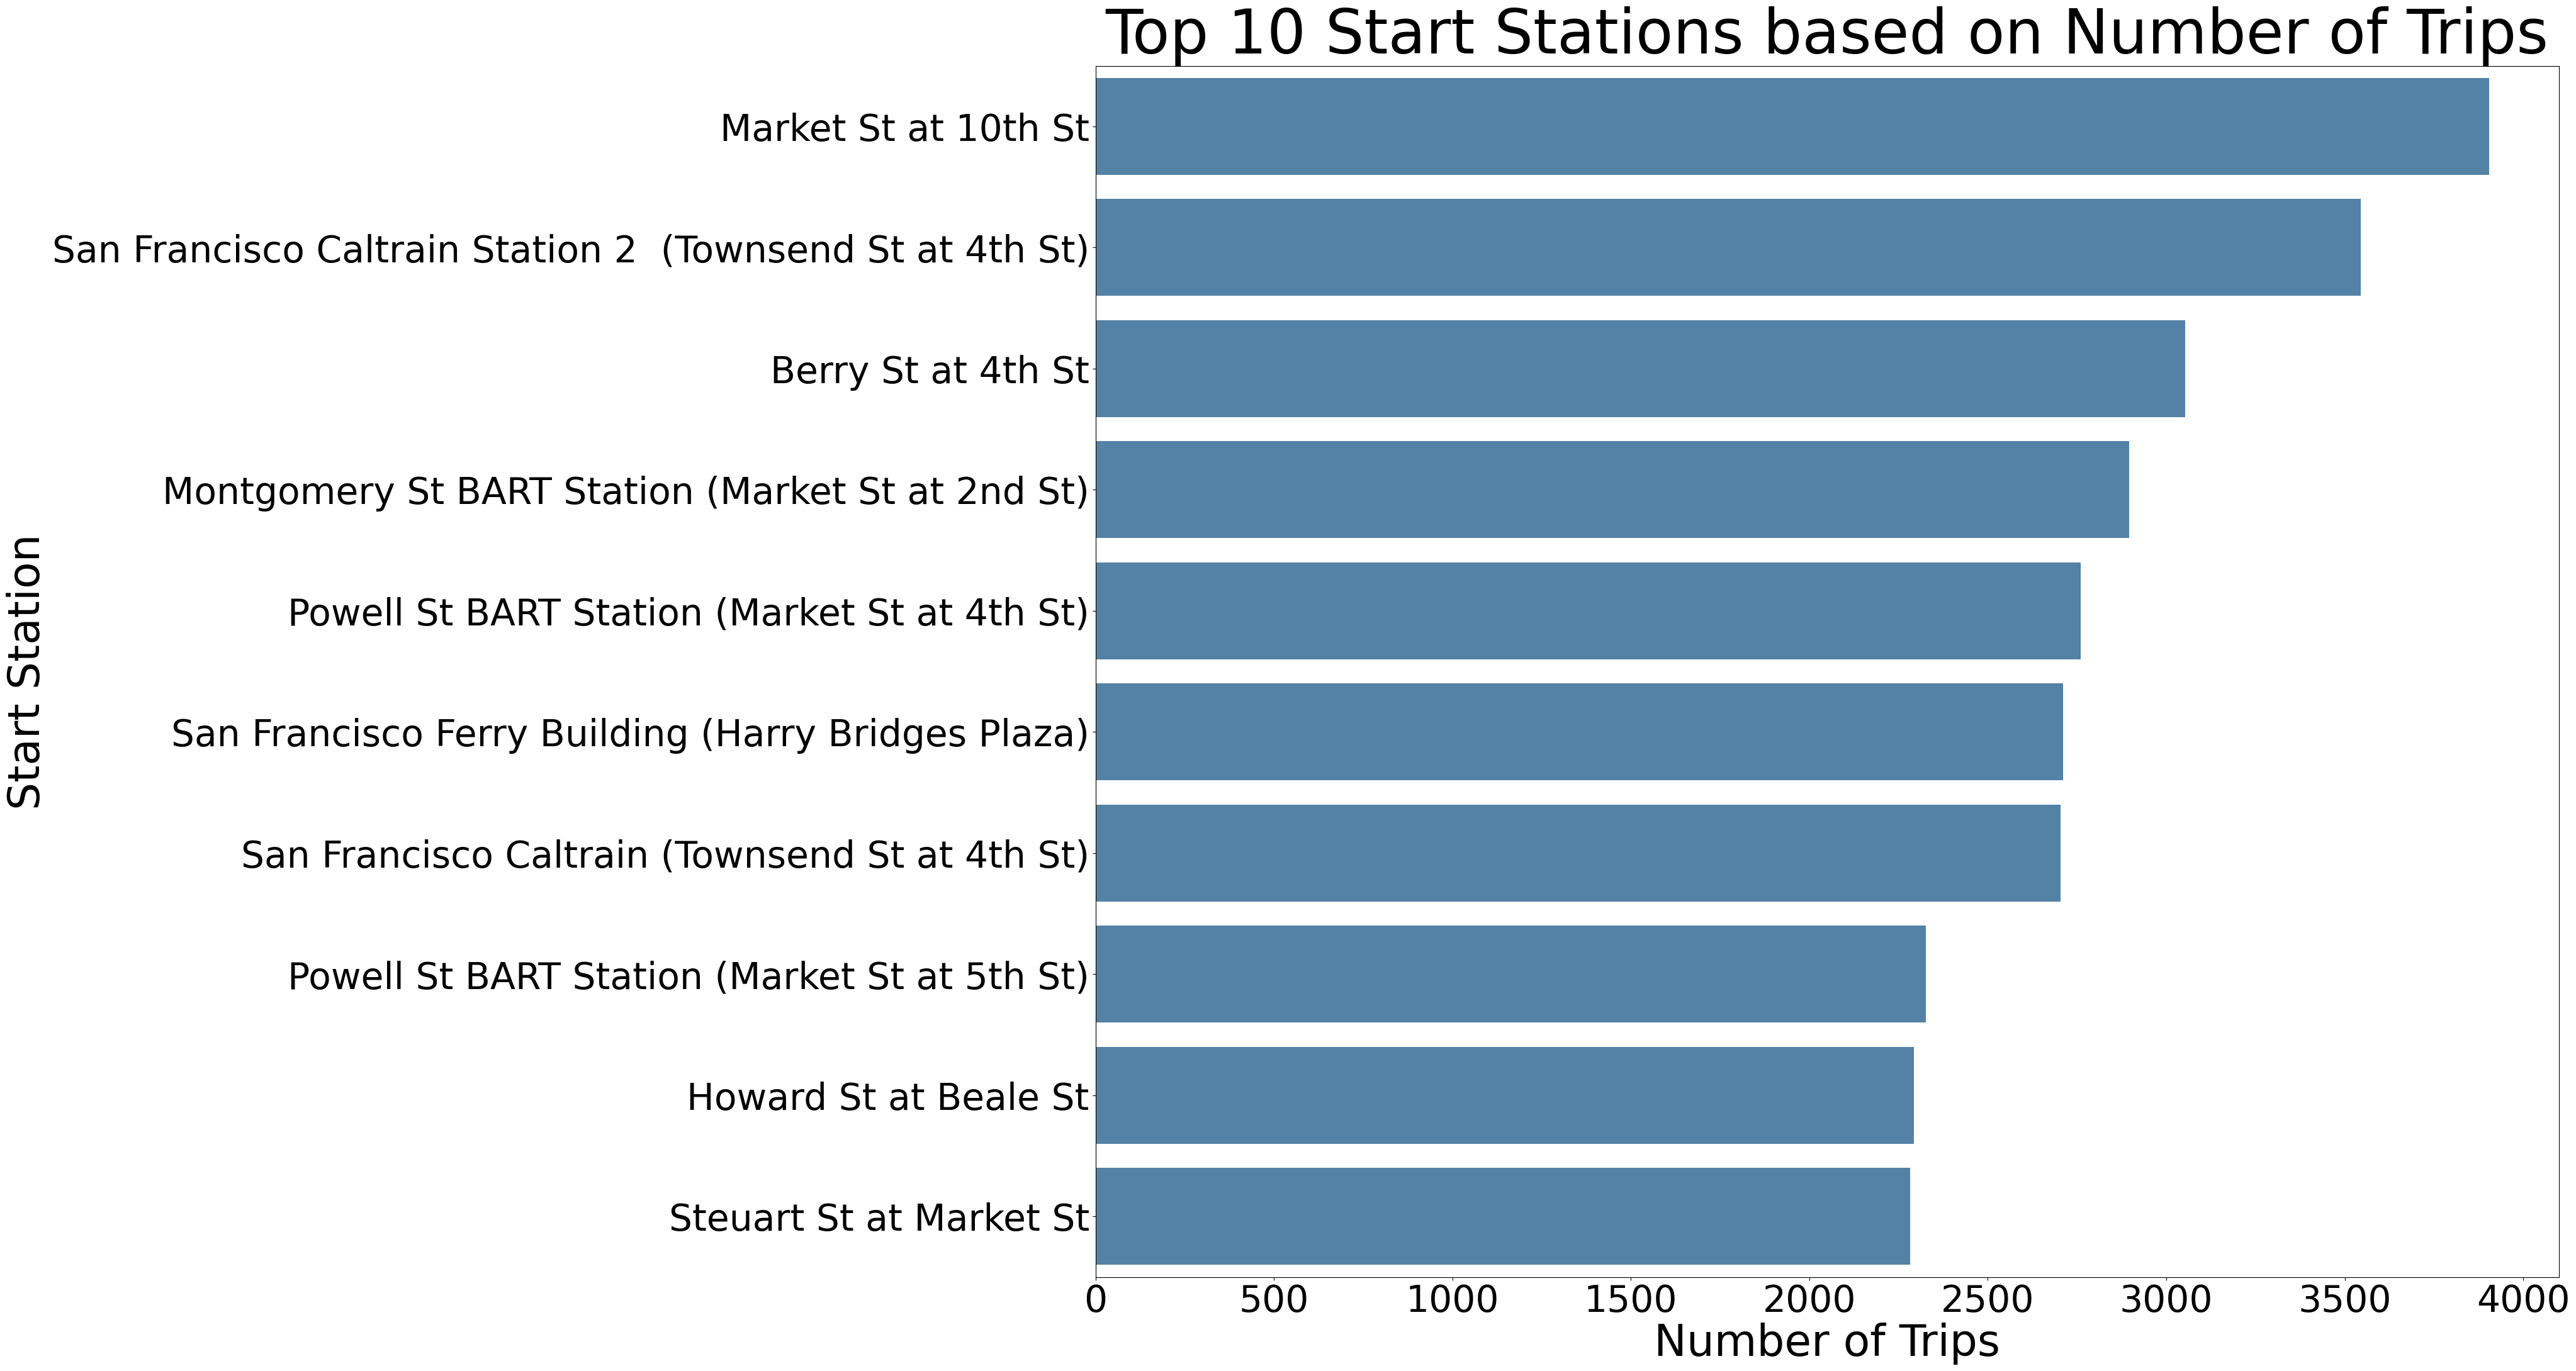

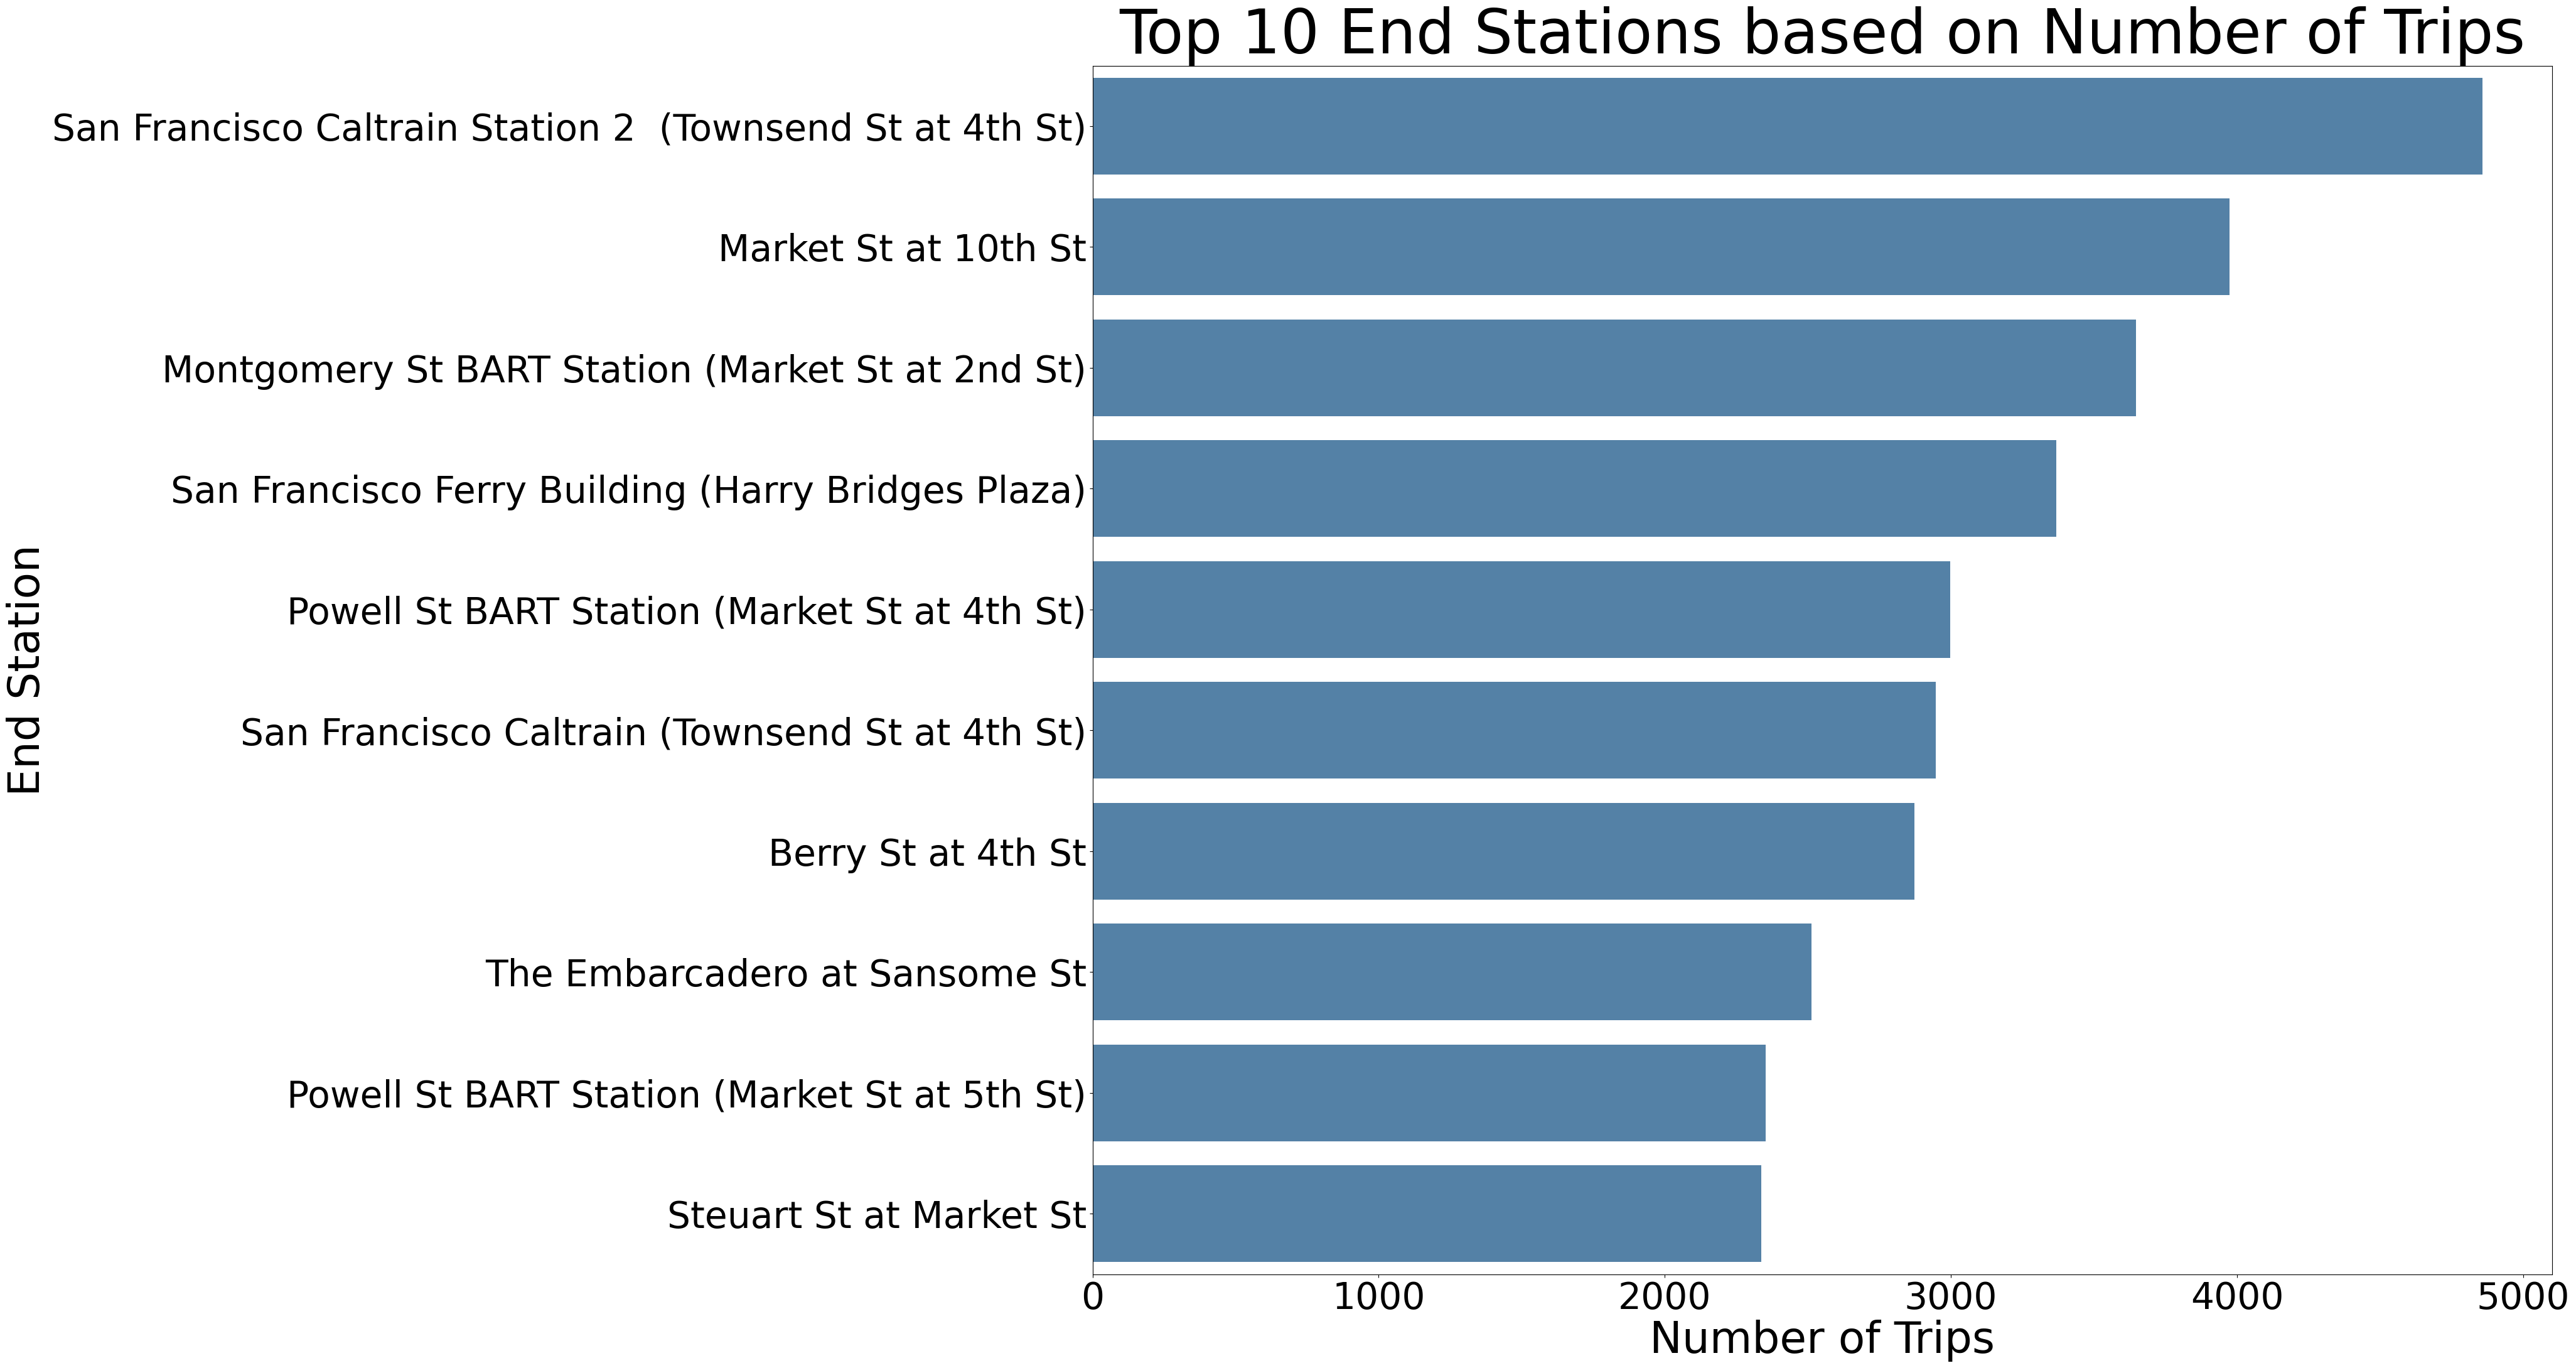

In [33]:
# top 10 start stations
start_stations_top10 = df['start_station'].value_counts().nlargest(10)
plt.figure(figsize=(30,25))
sb.barplot(x=start_stations_top10.values, y=start_stations_top10.index, color='steelblue')
plt.xlabel('Number of Trips', fontsize=50)
plt.ylabel('Start Station', fontsize=50)
plt.title('Top 10 Start Stations based on Number of Trips', fontsize=70)
plt.xticks(fontsize=42)
plt.yticks(fontsize=42)
plt.show();

# top 10 end stations
end_stations_top10 = df['end_station'].value_counts().nlargest(10)
plt.figure(figsize=(30,25))
sb.barplot(x=end_stations_top10.values, y=end_stations_top10.index, color='steelblue')
plt.xlabel('Number of Trips', fontsize=50)
plt.ylabel('End Station', fontsize=50)
plt.title('Top 10 End Stations based on Number of Trips', fontsize=70)
plt.xticks(fontsize=42)
plt.yticks(fontsize=42)
plt.show();

The bar plots show the number of trips for each station,can provide insights into user behavior and travel patterns. These visualizations indicate the most popular stations for starting and ending trips, which could be useful for bike share operators in terms of optimizing the availability of bikes and parking spaces at these locations.

From the top 10 start stations bar plot, it can be observed that the most popular start station is Market St (10th St), followed by San Francisco Caltrain (Townsend St at 4th St) and Berry St (at 4th St).
From the top 10 end stations bar plot, it can be observed that the most popular end station is San Francisco Caltrain Station 2 (Townsend St at 4th St), followed by Market St. (at 10th St) and Montgomery St BART Station (Market St at 2nd St).This information can be useful in determining popular locations for bike sharing and identifying areas where bike sharing infrastructure may need to be expanded or improved.


## 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

 

The first heatmap shows the number of bike-share trips by the hour of the day, day of the week, and membership type. The visualization reveals that on weekdays, especially during rush hours, there are more trips made by subscribers than by customers. In contrast, the weekends have a more even distribution of trips made by both subscribers and customers throughout the day.

The second visualization is a grid of bar plots that show the number of bike-share trips by the day of the week, user type, and gender. The plots reveal that there are more trips made by males than by females and other genders, and that subscribers make more trips than customers on each day of the week.

The third visualization shows the distribution of trip durations by gender and user type using violin plots. The plots show that customers tend to have longer trip durations than subscribers for each gender, and that males tend to have longer trip durations than females and other genders for both customer and subscriber categories.

The fourth visualization is a heatmap that shows the average trip duration by the day of the week and user type. The heatmap reveals that, on average, customers tend to have longer trip durations than subscribers on each day of the week, and that trip durations tend to be longer on the weekends than on weekdays.

The last two visualizations show the top 10 start and end stations based on the number of trips. These plots reveal that the top stations are located in the busiest parts of the city, such as tourist attractions, transportation hubs, and commercial centers. The stations that appear in both plots are likely the most popular stations for bike-share trips.

Overall, the visualizations provide insight into how the usage of the bike-share system varies by user type, gender, day of the week, and time of day. The different visualizations highlight different aspects of the data, and together they give a more complete picture of the patterns in bike-share usage.



### Were there any interesting or surprising interactions between features?



In the heatmap of the number of bike-share trips by day, days of the week, and membership type, we can see that the highest number of trips are taken on weekdays during the morning and evening rush hours by subscribers. This indicates that subscribers are most likely using the service to commute to and from work or school. On weekends, the number of trips is more evenly distributed throughout the day and across user types.

The grip visualization of the number of bike-share trips by day of the week, user type, and gender shows that male subscribers are the most frequent users of the service, while female customers are the least frequent. This gender disparity is more pronounced among customers than subscribers.

The violin plot of the distribution of trip durations by gender and user type shows that female customers have longer trip durations than male customers, while male subscribers have longer trip durations than female subscribers. This suggests that male subscribers are using the service for longer, more frequent trips, while female customers may be using the service for more leisurely or sightseeing trips.

The heatmap of the average trip duration by day of the week and user type shows that customers have longer trip durations than subscribers, especially on weekends. This indicates that customers may be using the service for more leisurely or sightseeing trips, while subscribers are more likely using the service for commuting.

Finally, the bar plots of the top 10 start and end stations based on number of trips show that the most popular stations are located in busy, densely populated areas such as downtown, near universities, and near popular tourist destinations. This suggests that the service is primarily used for short, point-to-point trips within urban areas.


## 

## Conclusions

In conclusion, I analyzed the Ford GoBike trip data for February 2019 and explored various aspects of bike usage patterns. It was noticed the majority of the riders were male subscribers who used the bikes for short commutes during weekdays, especially during peak hours. Additionally, it was realized most of the rides lasted less than 30 minutes and covered a distance of less than 2 miles.

Also, it was discovered that the top 10 start and end stations based on the number of trips, are clustered around downtown areas and major transit hubs, indicating that the program is most heavily used in these areas, and it was interesting to note that there was some overlap between them. 
The most popular start and end station was the San Francisco Caltrain Station, which suggests that it is a major transportation hub for bike riders. Furthermore, subscribers tend to use the bikes more frequently and for shorter trips than customers, who tend to use the bikes for longer trips.

The program is also most popular on weekdays, particularly during rush hour periods, suggesting that it is used primarily for commuting or short trips within the city. 

Overall, the analysis provided valuable insights into the usage patterns of the Ford GoBike service in February 2019. The bike sharing program appears to be a convenient and popular option for short trips within the city, particularly for commuters and those traveling to and from major transit hubs. These insights can be used to improve the service, such as by focusing on popular stations and peak usage times, and by tailoring the service to the needs of different types of riders. 
 

## 